IMP UPDATE TO BE DONE WHILE ADDING NEW FILES

Naming Convention
1) Only pdf's will be processed here excel's will be ignored
2) Always name like {company_name}-{year}
Here if company name is more than 1 word it should be seperated by "_" and most importantly
the year is appended after the name with "-" (Underscore character)
3) DO NOT INCLUDE ESG Words in the name, as names of these companies are excluded in the wordcloud
4) gcp-2021 pdf files are empty check before any adding pdf to repository -Add to sharepoint
5) Place this script in a folder of PDF's
6) Deutsche telekom has some PyPDF2 extraction doesn't work for this.


# Code Begins Here


In [2]:
import PyPDF2
import wordcloud
import nltk
import collections
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import csv
import re
import ast
import operator

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk import bigrams
from collections import Counter
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from PyPDF2 import PdfFileReader

In [4]:
keywordFilter=['n/a','year','annual','group','well','airport','air','k+s','frankfurt','report','company','companys','aircraft','also','may','space','p.',"'s", 'e.on']
bigramwordfilter = ['2019/20','n/a','2019','2020','2021','co.','kgaa','co₂', 'per','cent','non','201920']
punctuations = ['(',')',';',':','[',']',',','.','--','-','#','!','*','"','%','``',"'"]

In [5]:
def readpdffiles():
   path= os.getcwd()
   os.chdir(path)
   pdfs = []
   for file in glob.glob("*.pdf"):
      pdfs.append(file)
   return pdfs

In [6]:
def read_file_pypdf(filepath):
    pdfFileObj = open(filepath,'rb')
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    num_pages = pdfReader.numPages
    text = ""
    # Read all the pages
    for pg in range(num_pages):
        page = pdfReader.getPage(pg)
        text += page.extractText()
    return text 

In [7]:
def read_file(filepath):
    
    text = ""
    if not os.path.isfile(filepath):
        print(f'Invalid file:{filepath}')
    else:
        return read_file_pypdf(filepath)

    return text

In [8]:
def extract_keywords(text, ignore_words = [],
                     min_word_length = 0,
                     ignore_numbers = True,
                     ignore_case = True):
    # Remove words with special characters
    filtered_text = ''.join(filter(lambda x:x in string.printable, text))
    
    # Create word tokens from the text string
    tokens = word_tokenize(filtered_text)
    
    # List of punctuations to be ignored 
    punctuations = ['(',')',';',':','[',']',',','.','--','-','#','!','*','"','%','"','``']
    
    # Get the stopwords list to be ignored
    stop_words = stopwords.words('english')
    stop_words = list(stop_words)
    ignore_words.extend(stop_words)
    # Convert ignore words from user to lower case
    ignore_words_lower = [x.lower() for x in ignore_words]
    
    # Combine all the words to be ignored
    all_ignored_words = punctuations + stop_words + ignore_words_lower
    
    # Get the keywords list
    keywords = [word.lower() for word in tokens \
                    if  word.lower() not in all_ignored_words
                    and len(word) >= min_word_length]    

    # Remove keywords with only digits
    if ignore_numbers:
        keywords = [keyword for keyword in keywords if not keyword.isdecimal()]
    if ignore_numbers:
        keywords = [keyword for keyword in keywords if not keyword.isdigit()]

    # Return all keywords in lower case if case is not of significance
    if ignore_case:
        keywords = [keyword.lower() for keyword in keywords]
    
    return keywords

In [9]:
def clean(text):
    
    # removing paragraph numbers
    text = re.sub('/',' ',str(text))
    # removing new line characters
    text = re.sub('\n ','',str(text))
    text = re.sub('\n',' ',str(text))
    # removing apostrophes
    text = re.sub("'s",'',str(text))
    # removing hyphens
    text = re.sub("-",' ',str(text))
    text = re.sub("— ",'',str(text))
    text = re.sub("ó",'o',str(text))
    # removing quotation marks
    text = re.sub('\"','',str(text))
    # removing salutations
    text = re.sub("Mr\.",'Mr',str(text))
    text = re.sub("Mrs\.",'Mrs',str(text))
    # removing any reference to outside text
    text = re.sub("[\(\[].*?[\)\]]", "", str(text))
    text = re.sub('[0-9]+.\t',' ',str(text))
    text = re.sub('\b[12][0-9]{2,}\b', ' ', str(text))
    text = re.sub(r'\d','',str(text))
    
    return text

In [10]:
a=readpdffiles()
names = []
year = []
keywordname =[]

for pdf in a:
    parts = re.split('-|.pdf',pdf)
    newnames = parts[0].split('_')
    if len(newnames) == 1:
        names.append(newnames[0])
        keywordname.append(newnames[0])
    elif len(newnames)==2:
        names.append(newnames[0]+" "+newnames[1])
        keywordname.append(newnames[0])
        keywordname.append(newnames[1])
    # Can extend by using for loop but considering max 3 names here
    else:
        names.append(newnames[0]+" "+newnames[1]+" "+newnames[2])
        keywordname.append(newnames[0])
        keywordname.append(newnames[1])
        keywordname.append(newnames[2])
    anew=[]
    anew = re.split(r"-|.pdf",pdf)
    year.append(anew[1])
nameslower = list(map(str.lower,keywordname))
keywordFilter.extend(nameslower)
bigramwordfilter.extend(nameslower)
stop_words = set(stopwords.words('english'))
stop_words = list(stop_words)
bigramwordfilter.extend(stop_words)
bigramwordfilter.extend(punctuations)


In [ ]:
#Main code
for x in range(0,len(a)):
    pdftext = read_file(a[x])
    #Important parameter here  is:  keywordfilter which changes the game 
    keywords = extract_keywords(pdftext, keywordFilter ,min_word_length = 3)

    wordcloudwords= keywords
    word_could_dict=collections.Counter(wordcloudwords)
    topdict= dict(word_could_dict.most_common(150))
    strwords=[]
    strwords= str(topdict)

    #Tokenize text
    pdftext = clean(pdftext)
    tokens = nltk.word_tokenize(pdftext)
    #BigramWordFilter is a new list, filter only those out
    filtered_tokens = [token.lower() for token in tokens if token.lower() not in bigramwordfilter]
    #Process those bigrams
    bigram_finder = BigramCollocationFinder.from_words(filtered_tokens)
    bigram_finder.apply_word_filter(lambda w: len(w) < 3)
    bigrams = bigram_finder.ngram_fd.items()
    #Conversion of Bigrams to dict then String
    strbigrams = str(dict(sorted(bigram_finder.ngram_fd.items(), key=operator.itemgetter(1), reverse=True)[:5]))
    #print(strbigrams)
    myFile = open('wordcloudata.csv', 'a+', newline='')
    writer = csv.writer(myFile, dialect='excel')
    writer.writerow([x+1,names[x], year[x],strwords, strbigrams])    
    myFile.close()

#### REDUNDANT CODE IN CASE ERROR COMES IN SOME PDF, CAN CONTINUE DIRECTLY BY CHANGING VALUE 

In [ ]:
# -*- coding: utf-8 -*-
#For custom range only use this code
breaking_value=46   #Here put the value where pdf's gave error, you might need to check list of names and count accordingly or simply use csv last row to detemine
for x in range(breaking_value,len(a)):
    pdftext = read_file(a[x])
    #Important parameter here  is:  keywordfilter which changes the game 
    keywords = extract_keywords(pdftext, keywordFilter ,min_word_length = 2)
    wordcloudwords= keywords
    word_could_dict=collections.Counter(wordcloudwords)
    topdict= dict(word_could_dict.most_common(150))
    strwords=[]
    strwords= str(topdict)

    #Tokenize text
    tokens = nltk.word_tokenize(pdftext)
    #BigramWordFilter is a new list, filter only those out
    filtered_tokens = [token.lower() for token in tokens if token.lower() not in bigramwordfilter]
    #Process those bigrams
    bigram_finder = BigramCollocationFinder.from_words(filtered_tokens)
    bigram_finder.apply_word_filter(lambda w: len(w) < 3)
    bigrams = bigram_finder.ngram_fd.items()
    #Conversion of Bigrams to dict then String
    strbigrams = str(dict(sorted(bigram_finder.ngram_fd.items(), key=operator.itemgetter(1), reverse=True)[:5]))
    print(strbigrams)
    myFile = open('wordcloudata.csv', 'a+', newline='')
    writer = csv.writer(myFile, dialect='excel')
    #Added .encode because Co2 when 2 comes in subscript, unicode cannot map this character
    writer.writerow([x+1,names[x], year[x],strwords, strbigrams])    
    myFile.close()


## CODE ENDS HERE

##### Additional code to test

In [166]:

df = pd.read_csv('wordcloudata.csv',index_col=0, header=None)

 

In [186]:
#Choose by some logic when drop down is selected for company and year
wordictstring = df[3][1]
print(type(wordictstring))
worddict = ast.literal_eval(wordictstring)
print(type(worddict))

<class 'str'>
<class 'dict'>


In [187]:
#For checking purpose
def create_word_cloud(worddict, maximum_words = 100, bg = 'white', cmap='Dark2',
                     maximum_font_size = 256, width = 3000, height = 2000,
                     random_state = 42, fig_w = 15, fig_h = 10):
    
    # Convert keywords to dictionary with values and its occurences
    stop_words = stopwords.words('english')
    wordcloud1 = wordcloud.WordCloud(background_color=bg, max_words=maximum_words, colormap=cmap, 
                          stopwords=stop_words, max_font_size=maximum_font_size,
                          random_state=random_state, 
                          width=width, height=height).generate_from_frequencies(worddict)

    plt.figure(figsize=(fig_w,fig_h))
    plt.imshow(wordcloud1, interpolation="bilinear")
    plt.axis("off")
    plt.savefig("wordcloud.png", bbox_inches='tight')
    plt.show()
    plt.close()

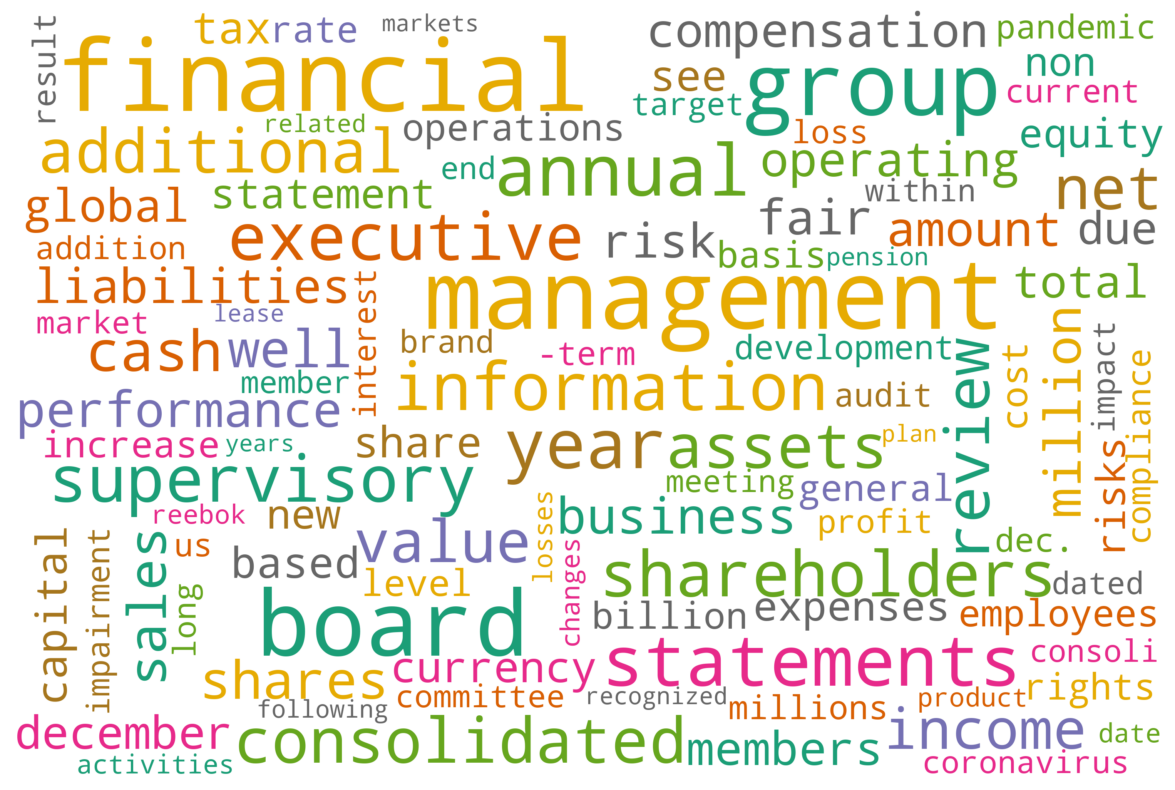

In [188]:
#For checking purpose

create_word_cloud(worddict)

--------------------Trying to extract bigrams--------------------------

In [178]:
# Independent Code for Bigrams
with open('Zeiss-2020.pdf', 'rb') as file:
    pdf = PdfFileReader(file)
    
    text =""
    # Iterate through each page of the PDF
    for page in range(pdf.getNumPages()):
        text += pdf.getPage(page).extractText()


tokens = nltk.word_tokenize(text)
stop_words = set(stopwords.words('english'))
stop_words = list(stop_words)
#stop_words.append(keywordFilter)

filtered_tokens = [token.lower() for token in tokens if token.lower() not in stop_words]

# Find bigrams frequency
bigram_finder = BigramCollocationFinder.from_words(filtered_tokens)
bigram_finder.apply_word_filter(lambda w: len(w) < 3)
bigrams = bigram_finder.ngram_fd.items()

# Print the bigrams frequency
'''for bigram, frequency in bigrams:
    print(bigram, frequency)'''
bigrams =collections.Counter(dict(bigrams))
strbigrams = str(dict(sorted(bigram_finder.ngram_fd.items(), key=operator.itemgetter(1), reverse=True)[:5]))
print(strbigrams)


Xref table not zero-indexed. ID numbers for objects will be corrected.


{('fiscal', 'year'): 85, ('zeiss', 'group'): 69, ('products', 'value'): 58, ('profile', 'business'): 53, ('year', '2019/20'): 51}


##### ---Processing after retreival of Bigram String---

##### Not useful for extraction , used after bigrams are read from DB

In [98]:
import operator
dictbigrams=dict(sorted(bigram_finder.ngram_fd.items(), key=operator.itemgetter(1), reverse=True)[:5])


In [91]:
#Using the str obtained from csv 
keys =list(dictbigrams.keys())
myanswer = [s1 +" "+ s2 for s1, s2 in keys]
myanswer

['management report',
 'group management',
 'financial statements',
 'executive board',
 'supervisory board']

In [28]:
print(bigrams_count.most_common(5))
print(type(bigrams_count))

bigrams =Counter(dict(bigrams))
print(type(bigrams))
print(bigrams.most_common(5))

[(('of', 'the'), 1423), (('MANAGEMENT', 'REPORT'), 629), (('GROUP', 'MANAGEMENT'), 627), (('REPORT', '-'), 622), (('in', 'the'), 599)]
<class 'collections.Counter'>
<class 'collections.Counter'>
[(('MANAGEMENT', 'REPORT'), 629), (('GROUP', 'MANAGEMENT'), 627), (('Executive', 'Board'), 402), (('Supervisory', 'Board'), 374), (('FINANCIAL', 'STATEMENTS'), 316)]


In [ ]:
stop_words = set(stopwords.words('english'))
filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

# Find bigrams frequency
bigram_finder = BigramCollocationFinder.from_words(filtered_tokens)
bigram_finder.apply_word_filter(lambda w: len(w) < 3)
bigrams = bigram_finder.ngram_fd.items()

# Print the bigrams frequency
for bigram, frequency in bigrams:
    print(bigram, frequency)